In [2]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits
import sympy as sy
from scipy.stats import norm, lognorm
from swyft.plot.mass import _get_jefferys_interval as interval
import random

In [3]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [4]:
names = ['grid_informed_power5',]
gridpoints = [50,55]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net'][round] = {}
        priors[name]['net_path'][round] = {}
        for gp in gridpoints:
            gridpoint = 'grid_point_' + str(gp)
            priors[name]['net_path'][round][gridpoint] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                             +round+'_gridpoint_'+str(int(gp))+'.pt')

            count = 0
            for combo in itertools.product(*priors[name]['hyperparams'].values()):
                if count == gp:
                    hyperparams_point = {}
                    for i, key in enumerate(priors[name]['hyperparams'].keys()):
                        hyperparams_point[key]=combo[i]
                    break
                count +=1
          
            priors[name]['net'][round][gridpoint] = network.NetworkCorner(
                nbins=priors[name]['A'].nbins,
                marginals=priors[name]['POI_indices'],
                param_names=priors[name]['A'].param_names,
                **hyperparams_point,
            )
            priors[name]['net'][round][gridpoint].load_state_dict(torch.load(priors[name]['net_path'][round][gridpoint]))

    # with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
    #     priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        # store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        # store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    # priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
sys.path

['/home/gertwk/ALPs_with_SWYFT/notebooks/thesis_results',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python39.zip',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/lib-dynload',
 '',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages',
 '/tmp/tmp8r4m_cx8',
 '/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim']

In [7]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])

In [8]:
def weight(exp,n_bins):
    x = np.linspace(-1,1,n_bins)
    return 0.5+0.5*np.cos(np.pi*np.sign(x)*np.abs(x)**exp)

In [9]:
stdnorm = norm()

In [10]:
def references2D(
    parsed_samples,
    x_freq = None,
    y_freq = None,
    x_exponent = None,
    y_exponent = None,
    x_phase = None,
    y_phase = None,
    min_freq = 1,
    max_freq = 1.4,
    min_freq_gap = 0.15,
    min_exponent = 0.8,
    max_exponent = 1.5,
    min_exponent_gap = 0.3,
    device = 'cpu'
):
  
    try:
        samples = parsed_samples['data']
    except IndexError:
        samples = parsed_samples

    data_length = len(samples[0]) 
    start_of_range1 = np.random.randint(0,data_length)
    end_of_range1 = (start_of_range1 + int(data_length/2)) #np.random.randint( start_of_range1+int(data_length/3) , start_of_range1+int(2*data_length/3) )
    exp1 = np.random.uniform(0.5,2)
    exp2 = np.random.uniform(0.5,2)
    range1 = np.arange(start_of_range1,end_of_range1)%data_length
    range2 = np.arange(end_of_range1,end_of_range1+(start_of_range1-end_of_range1)%data_length)%data_length

    reordered_range1 = (np.concatenate([range1,range2])-int(data_length/2))%data_length
    reordered_range2 = (np.concatenate([range2,range1])-int(data_length/2))%data_length
    weights1 = weight(exp1,data_length)[reordered_range1]
    weights2 = weight(exp2,data_length)[reordered_range2]

    samples1 = samples.copy()
    samples2 = samples.copy()
    
    # samples1 = samples[:,range1]
    # samples2 = samples[:,range2]
 
    bin_mins1 = np.min(samples1, axis=0)
    bin_maxes1 = np.max(samples1, axis=0)
    sums_of_standardized_bins1 = np.sum( weights1*((samples1-bin_mins1)/(bin_maxes1-bin_mins1)) ,axis=1)
    sums_of_standardized_bins1 = np.where(np.isinf(sums_of_standardized_bins1),0,sums_of_standardized_bins1)
    max_sum1 = np.max(sums_of_standardized_bins1)
    min_sum1 = np.min(sums_of_standardized_bins1)
    standardized_sums1 = (sums_of_standardized_bins1-min_sum1)/(max_sum1-min_sum1)

    bin_mins2 = np.min(samples2, axis=0)
    bin_maxes2 = np.max(samples2, axis=0)
    sums_of_standardized_bins2 = np.sum( weights2*((samples2-bin_mins2)/(bin_maxes2-bin_mins2)) ,axis=1)
    sums_of_standardized_bins2 = np.where(np.isinf(sums_of_standardized_bins2),0,sums_of_standardized_bins2)
    max_sum2 = np.max(sums_of_standardized_bins2)
    min_sum2 = np.min(sums_of_standardized_bins2)
    standardized_sums2 = (sums_of_standardized_bins2-min_sum2)/(max_sum2-min_sum2)

    sorted_sums1 = np.sort(standardized_sums1)
    sorted_sums2 = np.sort(standardized_sums2)

    fitted_parameters1 = lognorm.fit(standardized_sums1)
    fitted_parameters2 = lognorm.fit(standardized_sums2)
    
    phase_function1 = lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).cdf
    phase_function2 = lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).cdf

    phase_for_check1 = phase_function1(sorted_sums1)
    phase_for_check2 = phase_function2(sorted_sums2)
    phase1 = phase_function1(standardized_sums1)
    phase2 = phase_function2(standardized_sums2)

    if x_phase is None: x_phase = np.random.uniform(0,1)
    if y_phase is None: y_phase = np.random.uniform(0,1)

    freq_range = max_freq-min_freq
    if x_freq is None: x_freq = np.random.uniform(min_freq,max_freq)
    if y_freq is None: y_freq = np.random.uniform(min(x_freq+min_freq_gap,max_freq)-min_freq, freq_range+max(x_freq-min_freq-min_freq_gap,0))%(freq_range) + min_freq
    
    if x_exponent is None: x_exponent = np.random.uniform(min_exponent,1) if x_freq > y_freq else np.random.uniform(1,max_exponent)
    if y_exponent is None: y_exponent = np.random.uniform(min_exponent,min(1,x_exponent-min_exponent_gap)) if x_freq < y_freq else np.random.uniform(max(1,x_exponent+min_exponent_gap),max_exponent)

    x_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase_for_check1)**x_exponent + x_phase ))
    y_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase_for_check2)**y_exponent + y_phase ))
    
    x_values = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase1)**x_exponent + x_phase ))
    y_values = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase2)**y_exponent + y_phase ))

    random_variables = {
        'range1':range1,
        'range2':range2,
        'x_freq':x_freq,
        'y_freq':y_freq,
        'x_exponent':x_exponent,
        'y_exponent':y_exponent,
        'x_phase':x_phase,
        'y_phase':y_phase,
        'sums1':standardized_sums1,
        'sums2':standardized_sums2,
        'sorted_sums1':sorted_sums1,
        'sorted_sums2':sorted_sums2,
        'fitted_parameters1': fitted_parameters1,
        'fitted_parameters2': fitted_parameters2,
    }
    

    return np.array([x_values,y_values]).transpose(), np.array([x_values_for_check,y_values_for_check]).transpose(), random_variables

In [11]:
len(priors[name]['samples_prior'])

400000

In [16]:
try:
    del sys.modules['DRP_test']
except KeyError:
    pass
from DRP_test import get_drp_coverage, get_drp_coverage_torch, draw_DRP_samples_fast

In [19]:
%%time

def test_DRP_values(tries=3,n_samps=1000, n_prior_samps=1000, n_refs=100):
    name = names[0]
    which_truncation = priors[name]['which_truncation']
    which_grid_point = priors[name]['which_grid_point']
    POIs = priors[name]['POI_indices']
    A = priors[name]['A']
    bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])
    
    try:
        random_indices = random.sample(list(np.arange(n_samps*tries)), n_samps*tries)
    except ValueError:
        random_indices = list(np.concatenate([random.sample(list(np.arange(n_samps)), n_samps) for trial in range(tries)]))

    try:
        random_prior_indices = random.sample(list(np.arange(n_prior_samps*tries)), n_prior_samps*tries)
    except ValueError:
        random_prior_indices = list(np.concatenate([random.sample(list(np.arange(n_prior_samps)), n_prior_samps) for trial in range(tries)]))
        
    
    for gp in gridpoints:
        print()
        gridpoint = "grid_point_"+str(gp)
        print('Gridpoint ' + str(gp))
        for trial in range(tries):
    
            samples = swyft.Samples({key:val[random_indices[trial*n_samps:(trial+1)*n_samps]] for key,val in priors[name]['samples'].items()})
            prior_samples = swyft.Samples({key:val[random_prior_indices[trial*n_prior_samps:(trial+1)*n_prior_samps]] for key,val in priors[name]['samples_prior'].items()})
            
            draws1d = {}
            draws2d = {}
            weights1d = {}
            weights2d = {}

            
            for rnd in [0]:
                round = 'round_'+str(rnd)

                draws1d[round],draws2d[round],weights1d[round],weights2d[round] = draw_DRP_samples_fast(
                    priors[name]['net'][round][gridpoint],
                    trainer,
                    samples,
                    prior_samples,
                )
            
            print('Computing references...', flush=True, end="")
            references_2d = [
                references2D(samples)[0] for _ in range(n_refs)
            ]
            print(' done.')
        
        
            ecp_pp = { 'round_'+str(rnd) : [[{} for ref_list in references_2d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
            alpha_pp = { 'round_'+str(rnd) : [[{} for ref_list in references_2d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
            
            validation_sums = { 'round_'+str(rnd) : [{},{}] for rnd in range(which_truncation+1) }
            
            rows = len(POIs)
            
            for rnd in [0]:
                round = 'round_'+str(rnd)
                validation_sums[round][1][key] = 0
                for ref_i in range(len(references_2d)): 
                    for i, key in enumerate(list(draws2d[round].keys())[0]):  
                        ecp_pp[round][1][ref_i][key], alpha_pp[round][1][ref_i][key], _, _, _,_,f_score,_ = get_drp_coverage_torch(
                            draws2d[round][key],
                            samples['params'][:,[column,row]],
                            weights = weights2d[round][key],
                            theta_names=np.array(A.param_names)[[column,row]],
                            bounds = np.array(bounds)[[column,row]],
                            references = references_2d[ref_i],
                            device='cuda'
                        )
                        uncertainty = (interval((alpha_pp[round][1][ref_i][key]*n_samps).astype(int),n_samps)[:,1]-interval((alpha_pp[round][1][ref_i][key]*n_samps).astype(int),n_samps)[:,0])/2
                        validation_sums[round][1][key] += np.sum(((ecp_pp[round][1][ref_i][key]-alpha_pp[round][1][ref_i][key])/uncertainty)**2)/n_refs
                        break
            
            for i, key in enumerate(list(draws2d['round_0'].keys())[0]):
                print(key)
                for rnd in [0]:
                    print(validation_sums['round_'+str(rnd)][1][key])
                print()
                break
    

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 11.9 µs


In [12]:
%%time
test_DRP_values()


Gridpoint 50


Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
16.375436387525042



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
11.507890936416969



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
14.071782459519032


Gridpoint 55


Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
16.55151350616942



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
9.194062521487476



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
13.61947494003192

CPU times: user 2min 48s, sys: 3.66 s, total: 2min 52s
Wall time: 2min 51s


In [20]:
%%time
test_DRP_values(n_samps=1_000, n_prior_samps=10_000)


Gridpoint 50


Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
13.441108786559584



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
10.49834079652017



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
7.970448729109384


Gridpoint 55


Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
13.104263138762931



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
9.836650174053338



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
8.207537455848152

CPU times: user 36min, sys: 22.5 s, total: 36min 22s
Wall time: 36min 20s


In [21]:
%%time
test_DRP_values(n_samps=1_000, n_prior_samps=100_000)


Gridpoint 50


Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
9.938725022779929



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
10.609914330406953



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
13.45526387505012


Gridpoint 55


Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
8.89245522750768



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
12.60406737742662



Predicting: 0it [00:00, ?it/s]

Computing references... done.
['m' 'g']
12.715831767533434

CPU times: user 5h 41min 23s, sys: 7min 24s, total: 5h 48min 47s
Wall time: 5h 48min 25s


In [22]:
%%time
test_DRP_values(n_samps=1_000, n_prior_samps=400_000)


Gridpoint 50


IndexError: index 462614 is out of bounds for axis 0 with size 400000

In [24]:
alpha_pp[round][1][ref_i][key]

NameError: name 'alpha_pp' is not defined

In [80]:
mock_n = 100
mock_alpha = np.linspace(0,1,51)[:-1]
mock_rates = np.random.binomial(mock_n,mock_alpha)/mock_n
mock_upper = interval((mock_alpha*mock_n).astype(int),mock_n)[:,1]
mock_lower = interval((mock_alpha*mock_n).astype(int),mock_n)[:,0]
mock_uncertainty = (mock_upper-mock_lower)/2

mock_validation_sum = np.sum(((mock_rates-mock_alpha)/mock_uncertainty)**2)/1
mock_validation_sum

12.905897275888458

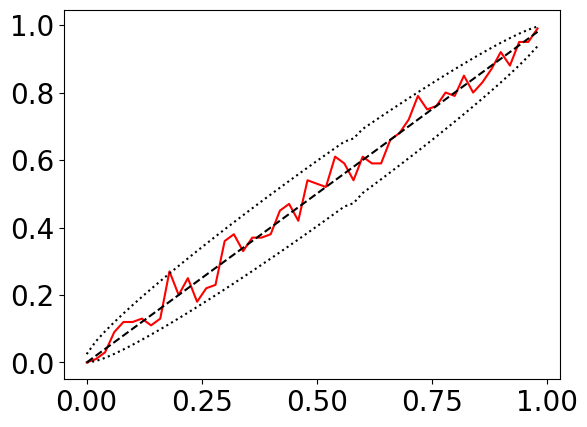

In [59]:
plt.plot(mock_alpha,mock_rates,'r')
plt.plot(mock_alpha,mock_alpha,'k--')
plt.plot(mock_alpha,mock_upper,'k:')
plt.plot(mock_alpha,mock_lower,'k:')

In [189]:
import time
class Timer():
    
    def __init__(self):
        self.start_time = None
        self.stop_time = None
    
    def start(self):
        self.start_time = time.time()
        
    def stop(self,what="Elapsed time"):
        self.stop_time = time.time()
        h,m,s = Timer.process_time(self.stop_time-self.start_time)
        print(what + ": "+str(h)+" h, "+str(m)+" min, "+str(s)+" sec.")
        self.start()

    def check(self,what="Elapsed time"):
        checked_time = time.time()
        if not self.start_time is None:
            time_increment = checked_time-self.start_time
        else:
            raise Error('There is no start time')
        h,m,s = Timer.process_time(time_increment)
        print(what + ": "+str(h)+" h, "+str(m)+" min, "+str(s)+" sec.")
    
    @staticmethod
    def process_time(s, round=False):
        h = int(s/3600)
        m = int((s-3600*h)/60)
        if round: 
            s = int(s-3600*h-60*m)
        else: 
            s = s-3600*h-60*m
        return h, m, s

T = Timer()

In [275]:
def test_theoretical_DRP_stability(mock_n=1000, mock_n_ref=10_000, mock_tries=1):
    # mock_n = 1000
    # mock_n_ref = 10_000
    # mock_tries = 10
    T.start()
    mock_bins = min(50, mock_n // min(10,mock_n))
    mock_alpha = np.linspace(0,1,mock_bins+1)[1:]
    mock_dx = mock_alpha[1]-mock_alpha[0]
    mock_interval = interval((mock_alpha*mock_n).astype(int),mock_n)
    mock_upper = mock_interval[:,1]
    mock_lower = mock_interval[:,0]
    mock_uncertainty = (mock_upper-mock_lower)/2
    mock_validation_sums = np.zeros((mock_tries,))
    for trial in range(mock_tries):
        print('Computing trial '+str(trial), flush=True, end='\r')
        mock_validation_sum = 0
        for ref_i in range(mock_n_ref):
            mock_f = np.random.uniform(size=(mock_n,))
            mock_histogram = torch.histogram(torch.tensor(mock_f), density=True, bins=mock_bins ,range=(0,1))
            mock_h = np.array(mock_histogram.hist)
            mock_rates = np.cumsum(mock_h)*mock_dx
            mock_validation_sum += np.sum(((mock_rates-mock_alpha)/mock_uncertainty)**2)/mock_n_ref
        mock_validation_sums[trial] = mock_validation_sum
    print()
    plt.hist(mock_validation_sums)

CPU times: user 54min 18s, sys: 1.34 s, total: 54min 19s
Wall time: 1min 56s


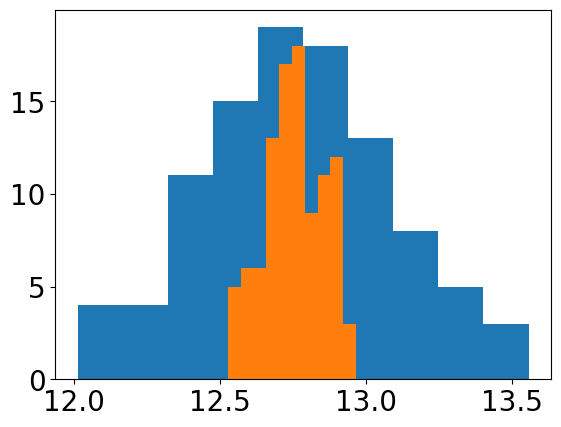

In [270]:
%%time
test_theoretical_DRP_stability(mock_n=1000, mock_n_ref=1_000, mock_tries=100)
test_theoretical_DRP_stability(mock_n=1000, mock_n_ref=10_000, mock_tries=100)

Computing trial 99
Computing trial 99
Computing trial 99
Computing trial 99
CPU times: user 2h 52min 50s, sys: 963 ms, total: 2h 52min 51s
Wall time: 6min 11s


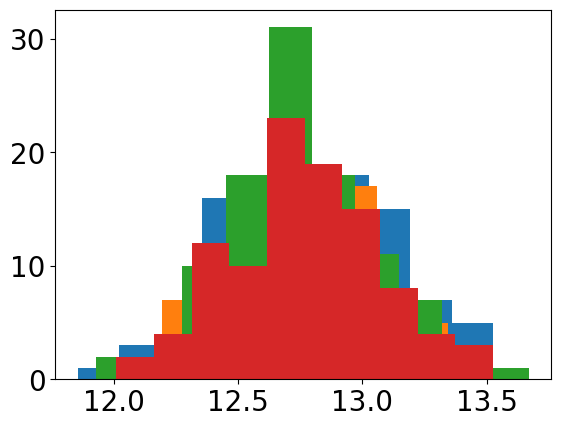

In [276]:
%%time
test_theoretical_DRP_stability(mock_n=500, mock_n_ref=1000, mock_tries=100)
test_theoretical_DRP_stability(mock_n=1000, mock_n_ref=1000, mock_tries=100)
test_theoretical_DRP_stability(mock_n=10_000, mock_n_ref=1000, mock_tries=100)
test_theoretical_DRP_stability(mock_n=100_000, mock_n_ref=1000, mock_tries=100)

In [348]:
%%time
test_theoretical_DRP_stability(mock_n=10, mock_n_ref=1000, mock_tries=100)
test_theoretical_DRP_stability(mock_n=500, mock_n_ref=1000, mock_tries=100)

IndexError: index 1 is out of bounds for axis 0 with size 1

Computing trial 199
Computing trial 199
Computing trial 199
CPU times: user 17h 4min 16s, sys: 29.1 s, total: 17h 4min 45s
Wall time: 36min 46s


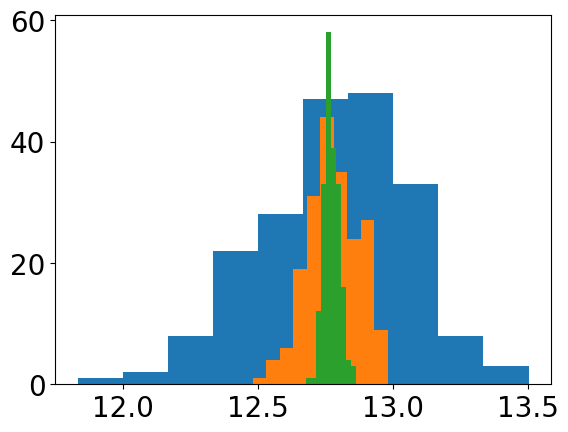

In [277]:
%%time
test_theoretical_DRP_stability(mock_n=500, mock_n_ref=1_000, mock_tries=200)
test_theoretical_DRP_stability(mock_n=500, mock_n_ref=10_000, mock_tries=200)
test_theoretical_DRP_stability(mock_n=500, mock_n_ref=100_000, mock_tries=200)

In [366]:
(10+10**0.5)/10

1.316227766016838

In [379]:
(1-3*10**(-0.5))

0.05131670194948623

In [393]:
def test_theoretical_f_stability(mock_bins=50,mock_n_per_bin=10, mock_n_ref=10_000, mock_tries=1):
    mock_n = mock_bins*mock_n_per_bin 
    mock_alpha = np.linspace(0,1,mock_bins+1)[1:]
    mock_dx = mock_alpha[1]-mock_alpha[0]
    mock_upper = 1+3*mock_n_per_bin**(-0.5)
    mock_lower = 1-3*mock_n_per_bin**(-0.5)
    mock_uncertainty = (mock_upper-mock_lower)/2
    mock_validation_sums = np.zeros((mock_tries,))
    for trial in range(mock_tries):
        print('Computing trial '+str(trial), flush=True, end='\r')
        mock_validation_sum = 0
        for ref_i in range(mock_n_ref):
            mock_f = np.random.uniform(size=(mock_n,))
            mock_histogram = torch.histogram(torch.tensor(mock_f), density=True, bins=mock_bins ,range=(0,1))
            mock_h = np.array(mock_histogram.hist)
            mock_validation_sum += np.sum(((mock_h-1)/mock_uncertainty)**2)/(mock_n_ref*mock_bins)
        mock_validation_sums[trial] = mock_validation_sum
    print()
    plt.hist(mock_validation_sums, density=True)

Computing trial 199
Computing trial 199
CPU times: user 9min 22s, sys: 403 ms, total: 9min 22s
Wall time: 20.2 s


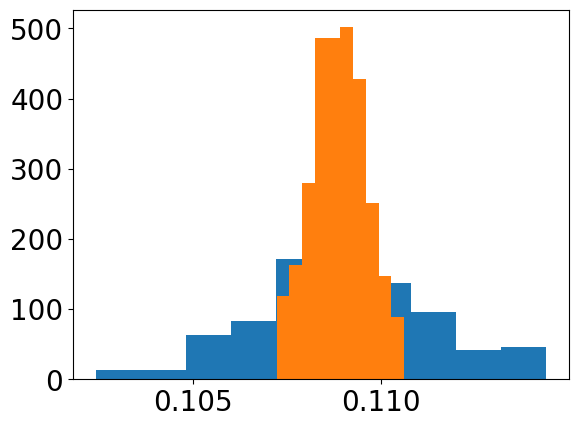

In [394]:
%%time
test_theoretical_f_stability(mock_bins=50, mock_n_ref=100, mock_tries=200)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=1000, mock_tries=200)

Computing trial 199
Computing trial 199
Computing trial 199
CPU times: user 1h 29min 7s, sys: 2.81 s, total: 1h 29min 9s
Wall time: 3min 11s


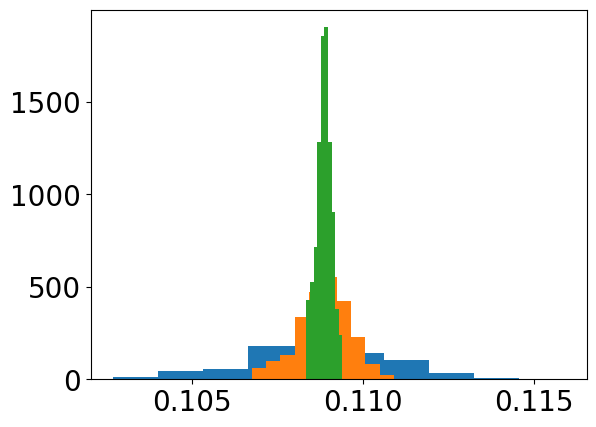

In [397]:
%%time
test_theoretical_f_stability(mock_bins=50, mock_n_ref=100, mock_tries=200)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=1000, mock_tries=200)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=10_000, mock_tries=200)

Computing trial 199
Computing trial 199
Computing trial 199
CPU times: user 1h 49min 3s, sys: 3.01 s, total: 1h 49min 6s
Wall time: 3min 54s


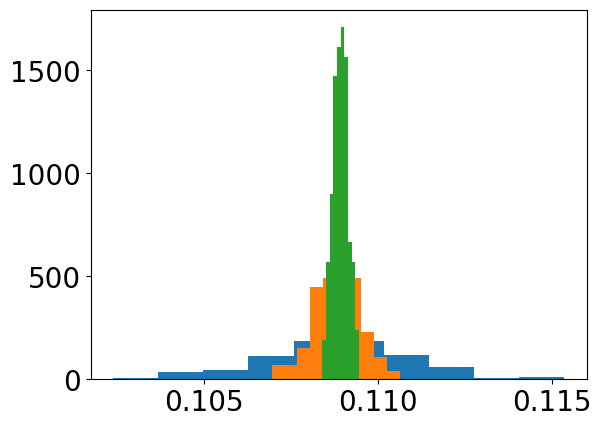

In [399]:
%%time
test_theoretical_f_stability(mock_bins=50, mock_n_ref=100, mock_tries=200, mock_n_per_bin=20)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=1000, mock_tries=200, mock_n_per_bin=20)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=10_000, mock_tries=200, mock_n_per_bin=20)

Computing trial 199
Computing trial 199
CPU times: user 2min 13s, sys: 119 ms, total: 2min 13s
Wall time: 4.81 s


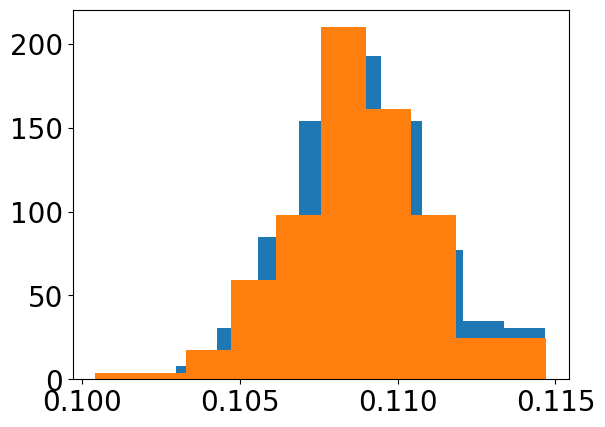

In [395]:
%%time
test_theoretical_f_stability(mock_bins=50, mock_n_ref=100, mock_tries=200)
test_theoretical_f_stability(mock_bins=50, mock_n_ref=100,mock_n_per_bin=100, mock_tries=200)

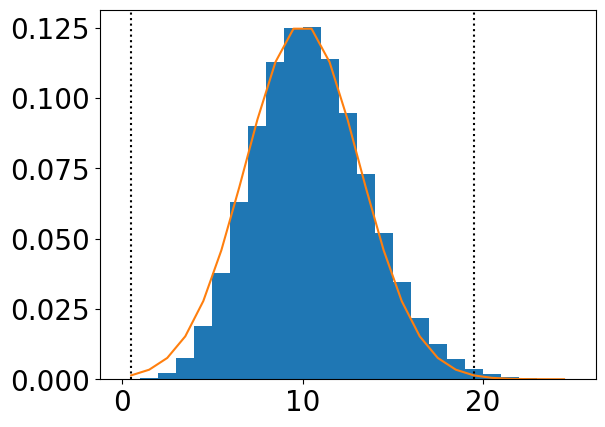

In [347]:
lam = 10
n = 10000000
ran=(max(0,lam-5*lam**0.5),int(lam+5*lam**0.5))
a = plt.hist(np.random.poisson(lam=lam,size=(n,)),ran[1]-ran[0], range=ran,density=1)
x = (a[1][1:]+a[1][:-1])/2

plt.plot(x,norm.pdf(x, loc=lam, scale=lam**0.5))
plt.axvline(lam-3*lam**0.5, color='k', linestyle=':')
plt.axvline(lam+3*lam**0.5, color='k', linestyle=':')

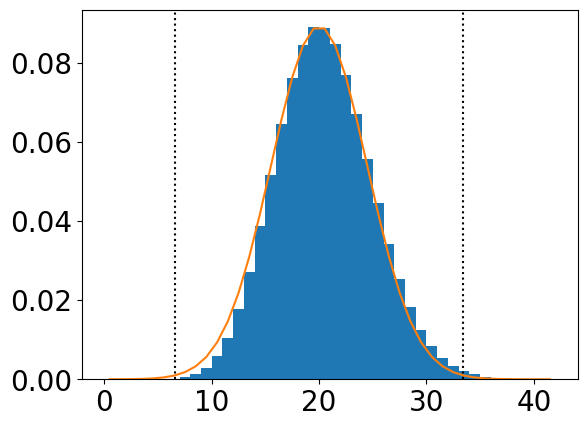

In [398]:
lam = 20
n = 10000000
ran=(max(0,lam-5*lam**0.5),int(lam+5*lam**0.5))
a = plt.hist(np.random.poisson(lam=lam,size=(n,)),ran[1]-ran[0], range=ran,density=1)
x = (a[1][1:]+a[1][:-1])/2

plt.plot(x,norm.pdf(x, loc=lam, scale=lam**0.5))
plt.axvline(lam-3*lam**0.5, color='k', linestyle=':')
plt.axvline(lam+3*lam**0.5, color='k', linestyle=':')

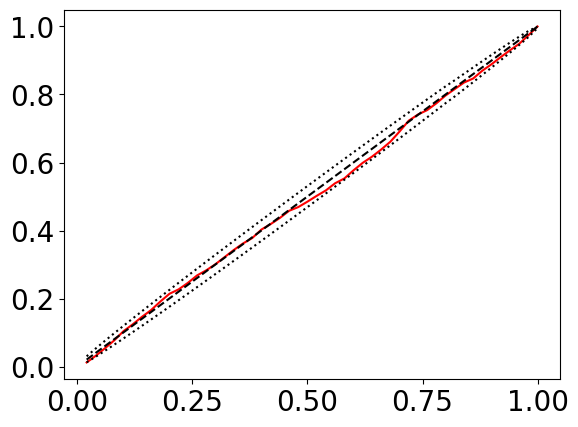

In [115]:
plt.plot(mock_alpha,mock_rates,'r')
plt.plot(mock_alpha,mock_alpha,'k--')
plt.plot(mock_alpha,mock_upper,'k:')
plt.plot(mock_alpha,mock_lower,'k:')

In [247]:
stuff = np.linspace(0,1,10000)
stuff_t = torch.tensor(stuff).to('cpu')

In [248]:
T.start()
np.histogram(stuff, density=True, bins=50, range=(0,1))
T.stop()

Elapsed time: 0 h, 0 min, 0.0005509853363037109 sec.


In [249]:
T.start()
torch.histogram(stuff_t, density=True, bins=50, range=(0,1))
T.stop()

Elapsed time: 0 h, 0 min, 0.0003006458282470703 sec.


In [298]:
norm.pdf()

NameError: name 'normal' is not defined

In [344]:
a

(array([4.08407147e-04, 1.82203189e-03, 6.06682617e-03, 1.51301048e-02,
        8.07969339e-02, 7.19646194e-02, 9.01786181e-02, 1.00053671e-01,
        1.91069664e-01, 7.57946064e-02, 5.82574995e-02, 4.16784894e-02,
        4.52009510e-02, 1.02158588e-02, 5.65433895e-03, 2.96909196e-03,
        2.20451858e-03, 3.21765631e-04, 1.38242419e-04, 7.37612908e-05]),
 array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ,
        11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  , 21.25,
        22.5 , 23.75, 25.  ]),
 <BarContainer object of 20 artists>)

In [337]:
np.random.poisson(lam=lam,size=(n,))

array([ 8,  7,  7, ...,  7,  8, 10])